In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

def generate_random_numbers01(N, dim, max_v = 10000):
    """
    Generate random numbers between 0 and 1
    max_v: maximum value used to generate random integers
    """
    random_ints = np.random.randint(max_v, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb)/(max_v - 1 - init_lb)

def generate_random_numbers(N, dim, max_v, lb, ub):
    """
    Generate random numbers between 'lb' and 'ub'
    """
    zero_to_one_points = generate_random_numbers01(N, dim, max_v)
    res = lb + (ub - lb)*zero_to_one_points
    return res

def generate_random_ring(N, r1, r2, max_v):
    """Generate random numbers in a ring between r1 and r2
    """
    radiuses = generate_random_numbers(N, 1, max_v, r1, r2)
    radians = generate_random_numbers(N, 1, max_v, 0, 2.0*math.pi)
    return radiuses, radians

def move_bottom_ring_and_assign(radiuses, radians, diffx, diffy):
    """
    Give the points within a ring, move the bottom half 'diffx' and 'diffy' along
    x and y directions respectively. Assign the bottom points to have sign -1
    """
    xs = radiuses * np.cos(radians)
    ys = radiuses * np.sin(radians)
    signs = np.ones(len(xs))

    for idx, r in enumerate(radiuses):
        rad = radians[idx]
        xi, yi = xs[idx], ys[idx]
        if rad > math.pi and rad < 2*math.pi:
            xs[idx] = xi + diffx
            ys[idx] = yi +  diffy
            signs[idx] = -1
    return xs, ys, signs

def perceptron(points, dim, max_it=100, use_adaline=False, 
               eta = 1, randomize=False, print_out = True):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    num_points = points.shape[0]
    for it in range(max_it):
        correctly_predicted_ids=  set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st*y #np.dot(w.T, x)*y
            if prod < -100: #avoid out of bound error
                st = -100
            threshold = 1 if use_adaline else 0
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta *(y-st)*x
                break #PLA picks one example at each iteration
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break
    
    rou = math.inf
    R = 0
    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod > 0:
            c +=1
        if prod < rou:
            rou = prod
        abs_x = np.linalg.norm(x)
        if abs_x > R:
            R = abs_x
    theoretical_t = (R**2) * (np.linalg.norm(w)**2)/rou/rou #LFD problem 1.3
    #w = w/w[-1]
    if print_out:
        print('Final correctness: ', c, '. Total iteration: ', it)
        print('Final w:', w)
    return w, it, theoretical_t

def linear_regression(X, y):
    XT = np.transpose(X)
    x_pseudo_inv = np.matmul(np.linalg.inv(np.matmul(XT,X)), XT)
    w = np.matmul(x_pseudo_inv,y)
    return w


Number of positive points:  1025
Number of negatives points:  975
Final correctness:  2000 . Total iteration:  49
Final w: [43.         -2.18766145 61.75971786]
Linear regression coefficients:  [ 0.25149577 -0.00946658  0.07855453]


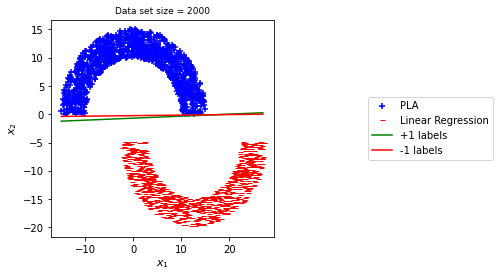

In [5]:
N = 2000
max_v = 10000
rad, thk = 10, 5
sep = 5
eta = 1
use_adaline=False
maxit = 1000
dim = 2

radiuses, radians = generate_random_ring(N, rad, rad+thk, max_v)
xs, ys, signs = move_bottom_ring_and_assign(radiuses, radians, rad + thk/2.0, -sep)
df = pd.DataFrame({'x1':xs.flatten(), 'x2':ys.flatten(), 'y':signs.flatten()})
df['x0'] = 1
df = df[['x0','x1','x2','y']]
positives = df.loc[df['y']==1]
negatives = df.loc[df['y']==-1]

figsize = plt.figaspect(1)
f, ax = plt.subplots(1, 1, figsize=figsize)

ps = ax.scatter(positives[['x1']].values, positives[['x2']].values, marker='+', c= 'b', label='+1 labels')
ns = ax.scatter(negatives[['x1']].values, negatives[['x2']].values, marker=r'$-$', c= 'r', label='-1 labels')
print('Number of positive points: ', len(positives))
print('Number of negatives points: ', len(negatives))

norm_g, num_its, _ = perceptron(df.values, dim, maxit, use_adaline, eta, randomize=False, print_out = True)    
x1 = np.arange(-(rad+thk), (rad+thk)+rad + thk/2)
norm_g = norm_g/norm_g[-1]
hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'g', label='Final Hypothesis')

w_lin = linear_regression(df[['x0','x1','x2']].values, df['y'].values)
print('Linear regression coefficients: ', w_lin)
linear = ax.plot(x1, -(w_lin[0]+w_lin[1]*x1), c = 'r', label='Linear Regression')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Data set size = %s'%N, fontsize=9)
ax.axis('tight')
legend_x = 2.0
legend_y = 0.5
ax.legend(['PLA', 'Linear Regression', 
           '+1 labels', '-1 labels', ], 
          loc='center right', bbox_to_anchor=(legend_x, legend_y))
#ax.set_ylim(bottom=lb, top=ub)
plt.show()